In [ ]:
!pip install kaggle pretty_midi torch torchvision torchaudio scikit-learn matplotlib tqdm > /dev/null

from google.colab import drive
drive.mount('/content/drive')

import os, re, json, glob, zipfile, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1) Konfigurasi path & unduh ZIP
# -------------------------
FILE_ID = "1VPx3nKsEPR-GV9v0QiNZRbA_Ptdt7lsA"   # ID ZIP gabungan (punyamu)
ZIP_PATH = Path("/content/dataset_mirex.zip")
EXTRACT_DIR = Path("/content/dataset_mirex")    # root ekstraksi

SAVE_DIR = Path("/content/drive/MyDrive/dataset_mirex/miditrainX")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

import gdown
if not ZIP_PATH.exists():
    print("Downloading ZIP via gdown...")
    gdown.download(id=FILE_ID, output=str(ZIP_PATH), quiet=False)
else:
    print("ZIP already exists:", ZIP_PATH)

print("Extracting ZIP ...")
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_DIR)

print("Done extract.")
print("EXTRACT_DIR content:")
for p in EXTRACT_DIR.iterdir():
    print(" -", p)



Mounted at /content/drive


Downloading...
From (original): https://drive.google.com/uc?id=1VPx3nKsEPR-GV9v0QiNZRbA_Ptdt7lsA
From (redirected): https://drive.google.com/uc?id=1VPx3nKsEPR-GV9v0QiNZRbA_Ptdt7lsA&confirm=t&uuid=4935fe7a-94cf-45bb-ab50-967ec067154d
To: /content/dataset_mirex.zip
100%|██████████| 320M/320M [00:04<00:00, 75.7MB/s]


Extracting ZIP ...
Done extract.
EXTRACT_DIR content:
 - /content/dataset_mirex/README.txt
 - /content/dataset_mirex/dataset


In [ ]:
from pathlib import Path
import os

EXTRACT_DIR = Path("/content/dataset_mirex")

# Cari folder yang punya subfolder Audio, Lyrics, MIDIs
candidates = []
for root, dirs, files in os.walk(EXTRACT_DIR):
    dirs_set = set(dirs)
    if {"Audio", "Lyrics", "MIDIs"}.issubset(dirs_set):
        candidates.append(Path(root))

if not candidates:
    raise RuntimeError("Gak nemu folder yang berisi Audio, Lyrics, MIDIs di bawah /content/dataset_mirex")

ROOT = candidates[0]
AUDIO_DIR = ROOT / "Audio"
LYRIC_DIR = ROOT / "Lyrics"
MIDI_DIR  = ROOT / "MIDIs"

print("ROOT terdeteksi :", ROOT)
print("AUDIO_DIR       :", AUDIO_DIR)
print("LYRIC_DIR       :", LYRIC_DIR)
print("MIDI_DIR        :", MIDI_DIR)

# Cari file .bat di bawah ROOT
BAT_FILES = sorted(ROOT.rglob("split-by-categories*.bat"))
print("\nBAT_FILES ditemukan:", len(BAT_FILES))
for b in BAT_FILES:
    print(" -", b)


ROOT terdeteksi : /content/dataset_mirex/dataset
AUDIO_DIR       : /content/dataset_mirex/dataset/Audio
LYRIC_DIR       : /content/dataset_mirex/dataset/Lyrics
MIDI_DIR        : /content/dataset_mirex/dataset/MIDIs

BAT_FILES ditemukan: 3
 - /content/dataset_mirex/dataset/split-by-categories-audio.bat
 - /content/dataset_mirex/dataset/split-by-categories-lyrics.bat
 - /content/dataset_mirex/dataset/split-by-categories-midi.bat


In [ ]:
import pandas as pd

DRIVE_DATASET_DIR = Path("/content/drive/MyDrive/dataset_mirex")
DATASET_ROOT = EXTRACT_DIR   # /content/dataset_mirex

master_tracks = pd.read_csv(DRIVE_DATASET_DIR / "master_tracks.csv")
split_global  = pd.read_csv(DRIVE_DATASET_DIR / "split_global.csv")

print("master_tracks:", master_tracks.shape)
print("split_global :", split_global.shape)
master_tracks.head()


master_tracks: (903, 8)
split_global : (903, 2)


,file_id,file_id_norm,emotion,label_id,label_idx,has_audio,has_lyrics,has_midi
0,1,1,Cluster 1,1,0,1,1,0
1,2,2,Cluster 1,1,0,1,0,0
2,3,3,Cluster 1,1,0,1,1,0
3,4,4,Cluster 1,1,0,1,1,1
4,5,5,Cluster 1,1,0,1,0,0


In [ ]:
# merge master_tracks dengan split_global
df = master_tracks.merge(split_global, left_on="file_id_norm", right_on="id", how="inner")

# filter hanya yang ada audio
df_audio = df[df["has_audio"] == 1].copy()

# tambahkan path audio
df_audio["audio_path"] = df_audio["file_id"].apply(
    lambda x: AUDIO_DIR / f"{int(x):03d}.mp3"
)

print("Total audio:", len(df_audio))
df_audio.head()


Total audio: 903


,file_id,file_id_norm,emotion,label_id,label_idx,has_audio,has_lyrics,has_midi,id,split,audio_path
0,1,1,Cluster 1,1,0,1,1,0,1,train,/content/dataset_mirex/dataset/Audio/001.mp3
1,2,2,Cluster 1,1,0,1,0,0,2,val,/content/dataset_mirex/dataset/Audio/002.mp3
2,3,3,Cluster 1,1,0,1,1,0,3,train,/content/dataset_mirex/dataset/Audio/003.mp3
3,4,4,Cluster 1,1,0,1,1,1,4,train,/content/dataset_mirex/dataset/Audio/004.mp3
4,5,5,Cluster 1,1,0,1,0,0,5,train,/content/dataset_mirex/dataset/Audio/005.mp3


In [ ]:
import numpy as np
import random

# seed biar konsisten
SEED = 123
random.seed(SEED)
np.random.seed(SEED)

# === bikin df_midi ===
df_midi = df[df["has_midi"] == 1].copy()
df_midi["midi_path"] = df_midi["file_id_norm"].apply(
    lambda x: MIDI_DIR / f"{int(x):03d}.mid"
)

df_midi["label"] = df_midi["label_idx"].astype(int)


print("Total baris has_midi==1:", len(df_midi))
df_midi[["file_id_norm", "label_idx", "midi_path"]].head()


Total baris has_midi==1: 196


,file_id_norm,label_idx,midi_path
3,4,0,/content/dataset_mirex/dataset/MIDIs/004.mid
7,8,0,/content/dataset_mirex/dataset/MIDIs/008.mid
8,9,0,/content/dataset_mirex/dataset/MIDIs/009.mid
11,12,0,/content/dataset_mirex/dataset/MIDIs/012.mid
18,19,0,/content/dataset_mirex/dataset/MIDIs/019.mid


In [ ]:
# cek file MIDI yang bener-bener ada
missing_midi = [p for p in df_midi["midi_path"] if not p.exists()]
print("Missing MIDI files:", len(missing_midi))
missing_midi[:10]


Missing MIDI files: 0


[]

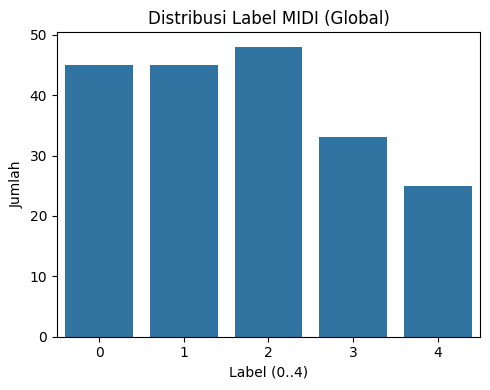

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.countplot(x="label", data=df_midi)
plt.title("Distribusi Label MIDI (Global)")
plt.xlabel("Label (0..4)")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()


In [ ]:
import pretty_midi
from tqdm.auto import tqdm

def extract_midi_features(path: Path):
    try:
        pm = pretty_midi.PrettyMIDI(str(path))
    except Exception:
        # kalau gak bisa di-parse, kembalikan None
        return None

    notes = []
    velocities = []
    pitches = []
    durations = []

    total_time = pm.get_end_time() + 1e-6

    for inst in pm.instruments:
        if inst.is_drum:
            continue
        for n in inst.notes:
            pitches.append(n.pitch)
            velocities.append(n.velocity)
            durations.append(n.end - n.start)
            notes.append(n)

    n_notes = len(notes)

    if n_notes == 0:
        return {
            "note_density": 0.0,
            "pitch_mean": 0.0,
            "pitch_std": 0.0,
            "vel_mean": 0.0,
            "vel_std": 0.0,
            "dur_mean": 0.0,
            "dur_std": 0.0,
            "polyphony": 0.0,
        }

    pitches = np.array(pitches)
    velocities = np.array(velocities)
    durations = np.array(durations)

    note_density = n_notes / total_time

    piano_roll = pm.get_piano_roll(fs=10)  # 10 fps
    polyphony = (piano_roll > 0).sum(axis=0).mean()

    return {
        "note_density": note_density,
        "pitch_mean": pitches.mean(),
        "pitch_std": pitches.std(),
        "vel_mean": velocities.mean(),
        "vel_std": velocities.std(),
        "dur_mean": durations.mean(),
        "dur_std": durations.std(),
        "polyphony": polyphony,
    }

midi_rows = []
for _, row in tqdm(df_midi.iterrows(), total=len(df_midi), desc="Extract MIDI features"):
    feats = extract_midi_features(row["midi_path"])
    if feats is None:
        continue
    feats["id"] = row["file_id_norm"]
    feats["label"] = row["label"]
    feats["split"] = row["split"]
    midi_rows.append(feats)

midi_feat_df = pd.DataFrame(midi_rows)
print("midi_feat_df:", midi_feat_df.shape)
midi_feat_df.head()


Extract MIDI features:   0%|          | 0/196 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


midi_feat_df: (194, 11)


,note_density,pitch_mean,pitch_std,vel_mean,vel_std,dur_mean,dur_std,polyphony,id,label,split
0,44.515565,62.649673,12.134618,116.867239,17.445810,0.267311,0.219182,4.757378,4,0,train
1,17.692276,53.090525,8.429144,126.945980,1.313665,0.327791,0.179788,4.814040,8,0,train
2,12.327315,50.995947,12.686660,88.634337,16.552431,0.237517,0.228289,2.815066,12,0,train
3,13.057153,60.872967,12.332504,115.033446,4.663825,0.337864,0.285838,3.866132,19,0,train
4,38.683162,53.137886,15.511601,103.989207,20.131385,0.126256,0.217774,4.372210,20,0,train


In [ ]:
# simpan fitur supaya kalau restart gak perlu ekstrak ulang
midi_feat_path = SAVE_DIR / "midi_features.csv"
midi_feat_df.to_csv(midi_feat_path, index=False)
print("✅ MIDI features disimpan di:", midi_feat_path)


✅ MIDI features disimpan di: /content/drive/MyDrive/dataset_mirex/miditrainX/midi_features.csv


In [ ]:
from sklearn.preprocessing import StandardScaler

feature_cols = [
    "note_density",
    "pitch_mean", "pitch_std",
    "vel_mean", "vel_std",
    "dur_mean", "dur_std",
    "polyphony",
]

train_midi = midi_feat_df[midi_feat_df["split"]=="train"].reset_index(drop=True)
val_midi   = midi_feat_df[midi_feat_df["split"]=="val"].reset_index(drop=True)
test_midi  = midi_feat_df[midi_feat_df["split"]=="test"].reset_index(drop=True)

X_train = train_midi[feature_cols].values
y_train = train_midi["label"].values

X_val   = val_midi[feature_cols].values
y_val   = val_midi["label"].values

X_test  = test_midi[feature_cols].values
y_test  = test_midi["label"].values

print("Train MIDI feat shape:", X_train.shape)
print("Val   MIDI feat shape:", X_val.shape)
print("Test  MIDI feat shape:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


Train MIDI feat shape: (152, 8)
Val   MIDI feat shape: (20, 8)
Test  MIDI feat shape: (22, 8)


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix
)

Cs = [0.1, 1.0, 10.0]
gammas = ["scale", 0.01, 0.1, 1.0]

best_val_f1 = -1
best_svm = None
best_params = None

for C in Cs:
    for gamma in gammas:
        clf = SVC(
            C=C,
            gamma=gamma,
            kernel="rbf",
            class_weight="balanced",   # penting, data imbalanced
            probability=True,          # perlu supaya bisa ambil predict_proba untuk fusion
            random_state=SEED,
        )
        clf.fit(X_train_scaled, y_train)
        val_pred = clf.predict(X_val_scaled)
        val_f1 = f1_score(y_val, val_pred, average="macro")
        print(f"C={C}, gamma={gamma} -> Val macro F1 = {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_svm = clf
            best_params = (C, gamma)

print(f"\n✅ Best params SVM = C={best_params[0]}, gamma={best_params[1]} "
      f"dengan Val macro F1 = {best_val_f1:.4f}")


C=0.1, gamma=scale -> Val macro F1 = 0.2260
C=0.1, gamma=0.01 -> Val macro F1 = 0.0190
C=0.1, gamma=0.1 -> Val macro F1 = 0.2667
C=0.1, gamma=1.0 -> Val macro F1 = 0.0190
C=1.0, gamma=scale -> Val macro F1 = 0.5638
C=1.0, gamma=0.01 -> Val macro F1 = 0.2250
C=1.0, gamma=0.1 -> Val macro F1 = 0.4400
C=1.0, gamma=1.0 -> Val macro F1 = 0.2705
C=10.0, gamma=scale -> Val macro F1 = 0.1924
C=10.0, gamma=0.01 -> Val macro F1 = 0.3816
C=10.0, gamma=0.1 -> Val macro F1 = 0.2490
C=10.0, gamma=1.0 -> Val macro F1 = 0.2923

✅ Best params SVM = C=1.0, gamma=scale dengan Val macro F1 = 0.5638


🎹 MIDI SVM Test Accuracy: 0.36363636363636365
🎹 MIDI SVM Test Macro F1: 0.29478991596638654

Classification report (MIDI SVM):
              precision    recall  f1-score   support

           0      0.333     0.500     0.400         2
           1      0.000     0.000     0.000         5
           2      0.455     0.833     0.588         6
           3      0.333     0.250     0.286         4
           4      0.200     0.200     0.200         5

    accuracy                          0.364        22
   macro avg      0.264     0.357     0.295        22
weighted avg      0.260     0.364     0.294        22

Confusion matrix:
 [[1 0 0 0 1]
 [1 0 1 2 1]
 [0 0 5 0 1]
 [0 0 2 1 1]
 [1 0 3 0 1]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


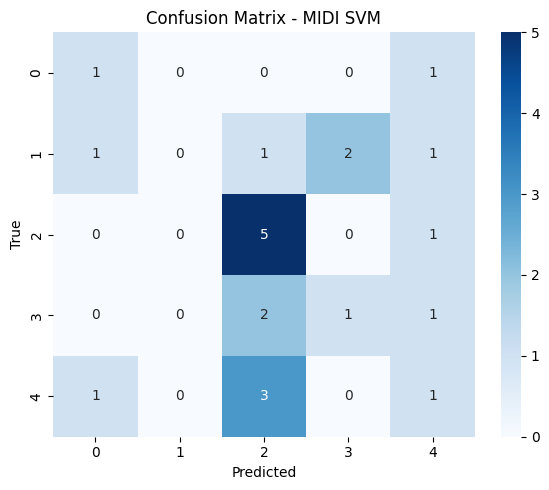

In [ ]:
test_pred  = best_svm.predict(X_test_scaled)
test_proba = best_svm.predict_proba(X_test_scaled)

test_acc = accuracy_score(y_test, test_pred)
test_f1  = f1_score(y_test, test_pred, average="macro")

print("🎹 MIDI SVM Test Accuracy:", test_acc)
print("🎹 MIDI SVM Test Macro F1:", test_f1)
print("\nClassification report (MIDI SVM):")
print(classification_report(y_test, test_pred, digits=3))

cm = confusion_matrix(y_test, test_pred)
print("Confusion matrix:\n", cm)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1,2,3,4],
            yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MIDI SVM")
plt.tight_layout()
plt.show()


In [ ]:
# id test buat konsisten
test_ids = test_midi["id"].tolist()
probs_array = np.array(test_proba)

# --- CSV untuk fusion ---
midi_prob_df = pd.DataFrame({
    "id": test_ids,
    "true_label": y_test,
})
for i in range(5):
    midi_prob_df[f"prob_cluster_{i+1}"] = probs_array[:, i]

midi_prob_path = SAVE_DIR / "midi_prob_for_fusion.csv"
midi_prob_df.to_csv(midi_prob_path, index=False)
print("✅ midi_prob_for_fusion.csv (SVM) disimpan di:", midi_prob_path)

# --- CSV untuk unimodal report ---
midi_unimodal_df = pd.DataFrame({
    "id": test_ids,
    "true_label": y_test,
    "pred_label": test_pred,
})
for i in range(5):
    midi_unimodal_df[f"prob_cluster_{i+1}"] = probs_array[:, i]

midi_unimodal_path = SAVE_DIR / "midi_unimodal_test_results.csv"
midi_unimodal_df.to_csv(midi_unimodal_path, index=False)
print("✅ midi_unimodal_test_results.csv (SVM) disimpan di:", midi_unimodal_path)


✅ midi_prob_for_fusion.csv (SVM) disimpan di: /content/drive/MyDrive/dataset_mirex/miditrainX/midi_prob_for_fusion.csv
✅ midi_unimodal_test_results.csv (SVM) disimpan di: /content/drive/MyDrive/dataset_mirex/miditrainX/midi_unimodal_test_results.csv


In [ ]:
from joblib import dump

midi_svm_path = SAVE_DIR / "best_midi_svm.joblib"
dump(best_svm, midi_svm_path)
print("✅ Best MIDI SVM disimpan di:", midi_svm_path)


✅ Best MIDI SVM disimpan di: /content/drive/MyDrive/dataset_mirex/miditrainX/best_midi_svm.joblib
